# Imports

In [1]:
import numpy as np
import pandas as pd
import fitz as fitz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import io as io

# Code

## Constants

In [2]:
# name of the master tracking sheet file
master_tracker_path: str = "../assets/tracker_images/Master Visitor Tracker Sheet.pdf"

# relative file path
data_path: str = "../assets/excel_files/observation_tables.xlsx"

# sheet name
main_sheet_name: str = "main data"
groups_sheet_name_base: str = "object group"

# export path
export_path: str = "../assets/output_files/room_18_bubble_plot.png"

## Loading XLSX

In [3]:
xlsx: pd.ExcelFile = pd.ExcelFile(data_path)
visitor_df: pd.DataFrame = pd.read_excel(xlsx, sheet_name=main_sheet_name, index_col=0)

num_observations: int = visitor_df.shape[0]

# get group dataframes in dictionary, where the key is the visitor's ID
group_dfs: dict[str, pd.DataFrame] = {}
for i in range(0, num_observations):
	visitor_id: str = "{0:0=3d}".format(visitor_df.loc[i, "visitor_id"])
	sheet_name: str = groups_sheet_name_base + " " + visitor_id
	group_df: pd.DataFrame = pd.read_excel(xlsx, sheet_name=sheet_name, index_col=0)
	group_dfs[visitor_id] = group_df

## Operations

### Support Functions

In [4]:
# dictionary of areas to investigate and their coordinates on the map, incluuding the positioning of the label
OBJECT_GROUP_NAMES: dict[str, tuple[int, int, bool]] = {
	"South Metopes II-V": (60, 400, False),
	"West Pediments": (50, 285, False),
	"South Metopes VI-IX": (60, 170, True),
	"South Metopes XXVI-XXIX": (525, 170, True),
	"East Pediments": (535, 285, False),
	"South Metopes XXX-XXXII": (525, 400, False),
	"Frieze Section 1": (190, 340, False),
	"Frieze Section 2": (160, 230, False),
	"Frieze Section 3": (290, 230, True),
	"Frieze Section 4": (420, 230, False),
	"Frieze Section 5": (400, 340, False)
}

# {name: (x, y, visitor %, avg dwell time, labeldirection)}
spots: dict[str, tuple[float, float, float, float, bool]] = {}
max_visitors: float = 0
max_dwell_time: float = 0

# load data into dictionary
for group, coords in OBJECT_GROUP_NAMES.items():
	total_visitors: int = 0
	total_dwell_time: int = 0
	for visitor_id, group_df in group_dfs.items():
		row = group_df.loc[group]
		if row.empty:
			raise Exception("Error in row fetching: " + group + ", sheet: " + visitor_id)
		if row.isnull()["visit_order"] == False:
			total_visitors += 1
			total_dwell_time += row["dwell_time"]
	visit_percent: float = float(total_visitors) / num_observations
	avg_dwell_time: float = float(total_dwell_time) / total_visitors
	if visit_percent > max_visitors:
		max_visitors = visit_percent
	if avg_dwell_time > max_dwell_time:
		max_dwell_time = avg_dwell_time

	spots[group] = (coords[0], coords[1], visit_percent, avg_dwell_time, coords[2])

In [5]:
def create_overlay(data: dict) -> None:
	"""
    Generates a bubble plot overlay on a base map PDF to visualize visitor data.

    The plot displays artifacts as bubbles, where:
    - Size represents the percentage of visitors who visited the artifact.
    - Color represents the average dwell time.                
    - Text labels indicate artifact names.

    Args:
        data: A dictionary where keys are artifact names and values are 
              tuples containing: (x_coord, y_coord, visitor_percent, 
              avg_dwell_time, label_direction).
    """
	doc: fitz.Document = fitz.open(master_tracker_path)
	page: fitz.Page = doc[0]

	pixmap: fitz.Pixmap = page.get_pixmap(dpi=72)
	width: float = page.rect.width
	height: float = page.rect.height
   
	img_data: np.ndarray = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(
		pixmap.h, pixmap.w, pixmap.n
	)

	fig: plt.Figure
	ax_map: plt.Axes
	ax_leg: plt.Axes
	fig, (ax_map, ax_leg) = plt.subplots(
		1, 2, 
		figsize=(width / 72 + 2, height / 72),
		gridspec_kw={'width_ratios': [width/36, 2]},
		constrained_layout=True
	)

	ax_map.imshow(img_data, extent=[0, width, height, 0])

	norm: mcolors.Normalize = mcolors.Normalize(vmin=0, vmax=max_dwell_time)
	cmap: mcolors.Colormap = plt.get_cmap('YlOrRd')

	for name, (x, y, visitor_percent, avg_dwell_time, direction) in data.items():
		color: tuple[float, float, float, float] = cmap(norm(avg_dwell_time))
		size: float = ((visitor_percent / max_visitors) * 35 + 10)

		ax_map.scatter(x, y - 75, s=size**2, c=[color], alpha=0.8, edgecolors="black", zorder=5)
		ax_map.text(
			x,
			y - ((size + 15) * (1 if direction else -1)) - 75,
			name,
			fontsize=9,
			ha="center",
			fontweight="bold",
			zorder=6,
			bbox=dict(
				facecolor='white',
				alpha=0.8,
				edgecolor='none',
				boxstyle='round,pad=0.3'
			)
		)

	sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cbar = fig.colorbar(
		sm,
		ax=ax_map,
		shrink=0.5,
		aspect=20,
		pad=0.08,
		location="left"
	)
	cbar.set_label('Avg Dwell Time (sec)', rotation=90, labelpad=15)
	
	ax_map.set_xlim(0, width)
	ax_map.set_ylim(height, 0)
	ax_map.axis("off")

	ax_leg.axis("off")
	ax_leg.set_xlim(0, 10)
	ax_leg.set_ylim(0, 100)

	legend_values = [25, 50, 75, 100]
	
	current_y = 70
	
	for val in legend_values:
		size_radius = ((val / 100) / max_visitors * 35 + 10)
		
		ax_leg.scatter(5, current_y, s=size_radius**2, c="gray", alpha=0.8, edgecolors="black", zorder=5)
		ax_leg.text(5+(size_radius / 8), current_y, str(val) + "%", va="center", fontsize=10)

		current_y -= (size_radius / 7 + 10)
	
	ax_leg.text(size_radius / 4 + 4, 50, '% of Visitors Observed that Visited Artifact', va="center", rotation=270)

	fig.suptitle("Room 18 Visitor Bubble Plot", y=1)
	plt.savefig(export_path, dpi=300, bbox_inches='tight')
	plt.show()
	
	doc.close()

### Execution

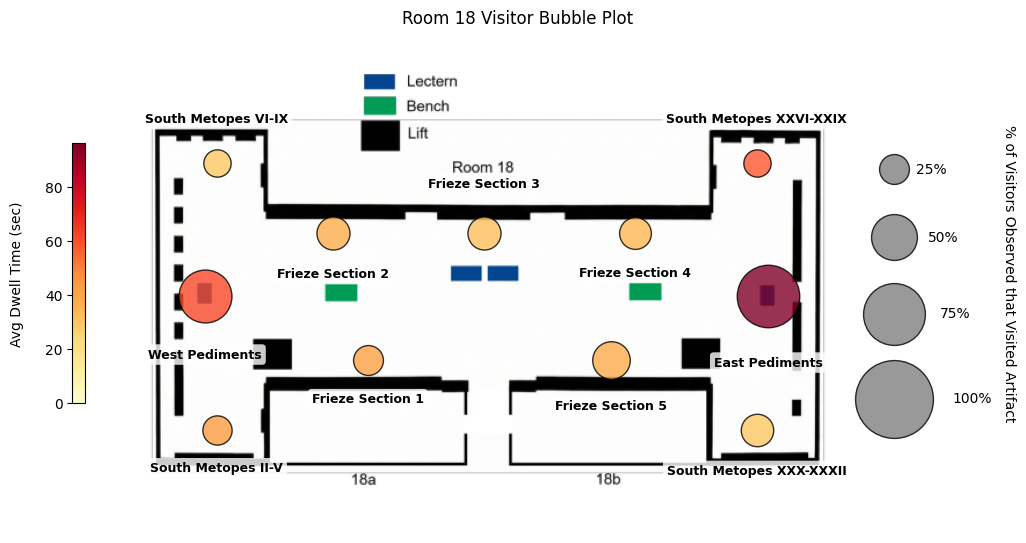

In [6]:
create_overlay(spots)